## AI Courses by OpenCV

Want to become an expert in AI? [AI Courses by OpenCV](https://opencv.org/university/) is a great place to start.

[![img](https://learnopencv.com/wp-content/uploads/2023/01/AI-Courses-By-OpenCV-Github.png)](https://opencv.org/courses/)

# Image Classification using OpenCV DNN

Let us now see one of the most common computer vision problems using the dnn module of OpenCV. We will use the **DenseNet121** deep neural network model for classifying images into 1000 classes of the famous [*ImageNet*](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjasLG-yKbyAhW3IbcAHRW1BZkQFnoECAwQAw&url=https%3A%2F%2Fwww.image-net.org%2F&usg=AOvVaw07SoUbpxRQk8ZNEiJoLqt5) dataset.

We will follow the following steps to classify an image:

1. Load the class names from .txt file and extract the labels. This has a list of all objects that can be identified by the model.
2. Load the pre-trained neural network model from disk using the `readNet` function.
3. Load the image from disk to pass through model
4. Prepare the input image by converting it to a blob using the `blobFromImage` function.
5. Set the blob as an input to the network using `setInput`
6. Use `forward` to pass the blob through the model to get the outputs.

In [1]:
if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/ude9orvkptlmoyp/AACkTfqT3skx6OzZ8jfQdwvTa?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
    !pip install --upgrade opencv-contrib-python
else:
    pass

module-code.zip     100%[===================>]  67.64M  54.6MB/s    in 1.2s    
mapname:  conversion of  failed
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 8.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76


In [2]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

## Read Class File
This will read the class file associated with the Imagenet dataset. It has 1000 objects and their class IDs. We will use this information to decode the predictions obtained from the network.

In [3]:
# Read the ImageNet class names.
with open('input/classification_classes_ILSVRC2012.txt', 'r') as f:
    image_net_names = f.read().split('\n')

# Save the names of all possible classifications, removing empty final line.
class_names = image_net_names[:-1]

# Verify the size, and inspect one of the classes by name.
print(len(class_names), class_names[0])

1000 tench, Tinca tinca


## Load Model

Loads the model using the readNet function. We will use a caffe model for this example.

In [4]:
# Loading the Classification model.
config_file = 'models/DenseNet_121.prototxt'
model_file = 'models/DenseNet_121.caffemodel'

model = cv2.dnn.readNet(model=model_file, config=config_file, framework='Caffe')


## Read Image

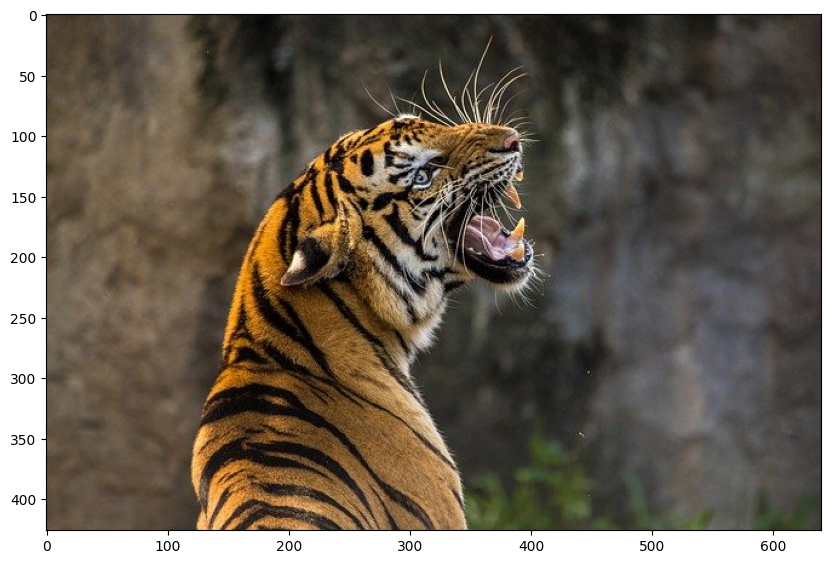

In [5]:
# Load and display the image from disk.
tiger_img = cv2.imread('input/image1.jpg')
plt.figure(figsize=[10, 10])
plt.imshow(tiger_img[:, :, ::-1]);

## Converting image to blob

In order to construct our blob, we need to read the `DenseNet_121.prototxt` file to find what blob specification it needs. At the top of this file, you would find:

```
name: "DENSENET_121"
input: "data"
input_dim: 1
input_dim: 3
input_dim: 224
input_dim: 224
```

This gives us the blob size we need to create, with input dimensions for:

* 1 = Number of images (per blob)
* 3 = Number of channels per image (full color, no alpha)
* (224, 224) = Height and width of the images

The mean and scalefactor to use also come from the model itself ([see here](https://github.com/shicai/DenseNet-Caffe)).

Let's consider the other flags used to create blob. In our example, we know we are reading a caffe model, which always have the BGR color space and thus we do not need to use swapRB. Additionally, consider the following impact of cropping:

<br>
<center>
<img src="https://opencv.org/wp-content/uploads/2021/09/c0-m13-crop-options.png" alt="Crop options">
</center>
<br>

In the cropped example, you can see some image data is lost. In fact, neural networks are quite good at understanding even squashed images. Because of this, there are many cases where cropping can actually reduce the quality of your results as you are removing data before passing the image through the network. If you believe your images have the object of interest centered, it may be worthwhile to use the crop flag.

Now we are ready to create the blob.

In [6]:
# Create blob from image.
blob = cv2.dnn.blobFromImage(
    image=tiger_img, scalefactor=0.017, size=(224, 224), mean=(104, 117, 123), swapRB=False, crop=False)


## Setting input value



In [7]:
# Set the input blob for the neural network.
model.setInput(blob)

## Detections using the DNN Model



In [8]:
# Pass the blob forward through the network.
outputs = model.forward()
final_outputs = outputs[0]

In [9]:
# Make all the outputs 1D, where each represents likihood of matching one of the 1K classification groups.
final_outputs = final_outputs.reshape(1000, 1)

# Get the class label index with the max confidence.
label_id = np.argmax(final_outputs)

# Convert score to probabilities for all matches.
probs = np.exp(final_outputs) / np.sum(np.exp(final_outputs))

print(probs[:10])
print("Max probability:", np.max(probs))

[[2.1499746e-10]
 [4.0102235e-10]
 [4.2768833e-10]
 [3.2427733e-10]
 [1.6526520e-11]
 [1.6457795e-11]
 [1.5199694e-11]
 [4.4728110e-09]
 [5.0411213e-09]
 [1.1915430e-09]]
Max probability: 0.9372196


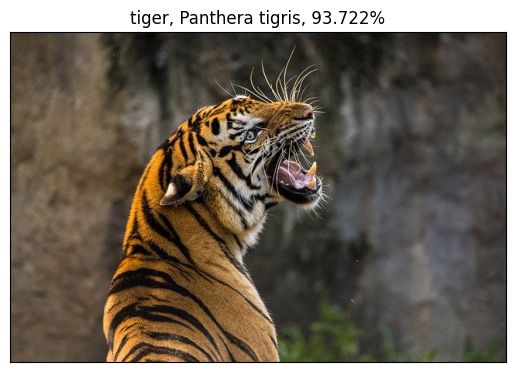

In [10]:
# Get the final highest probability
final_prob = np.max(probs) * 100.0

# Map the max confidence to the class label names.
out_name = class_names[label_id]
out_text = f"{out_name}, {final_prob:.3f}%"

# Display the image, best matched classification, and confidence.
plt.imshow(tiger_img[:, :, ::-1])
plt.title(out_text)
plt.xticks([]), plt.yticks([])
plt.show()

# 4. More examples

We can now give a try at applying the model to more examples. To more neatly use our workflow, we have defined the prios steps into the below reusable function.

In [11]:
def classify(img):
    image = img.copy()
    # Create blob from image.
    blob = cv2.dnn.blobFromImage(image=image, scalefactor=0.01, size=(224, 224), mean=(104, 117, 123))
    # Set the input blob for the neural network.
    model.setInput(blob)
    # Forward pass image blog through the model.
    outputs = model.forward()

    final_outputs = outputs[0]
    # Make all the outputs 1D.
    final_outputs = final_outputs.reshape(1000, 1)
    # Get the class label.
    label_id = np.argmax(final_outputs)
    # Convert score to probabilities
    probs = np.exp(final_outputs) / np.sum(np.exp(final_outputs))
    # Get the final highest probability
    final_prob = np.max(probs) * 100
    # Map the max confidence to the class label names.
    out_name = class_names[label_id]
    out_text = f"{out_name}, {final_prob:.3f}%"
    return out_text

Now let us use this function to classify a whole folder of images. Feel free to drop in some of your own jpg images into the `input` folder if you want to see what the model comes up with.

Classifying input/image6.jpg
Classifying input/image4.jpg
Classifying input/image3.jpg
Classifying input/image5.jpg
Classifying input/image1.jpg
Classifying input/image2.jpg


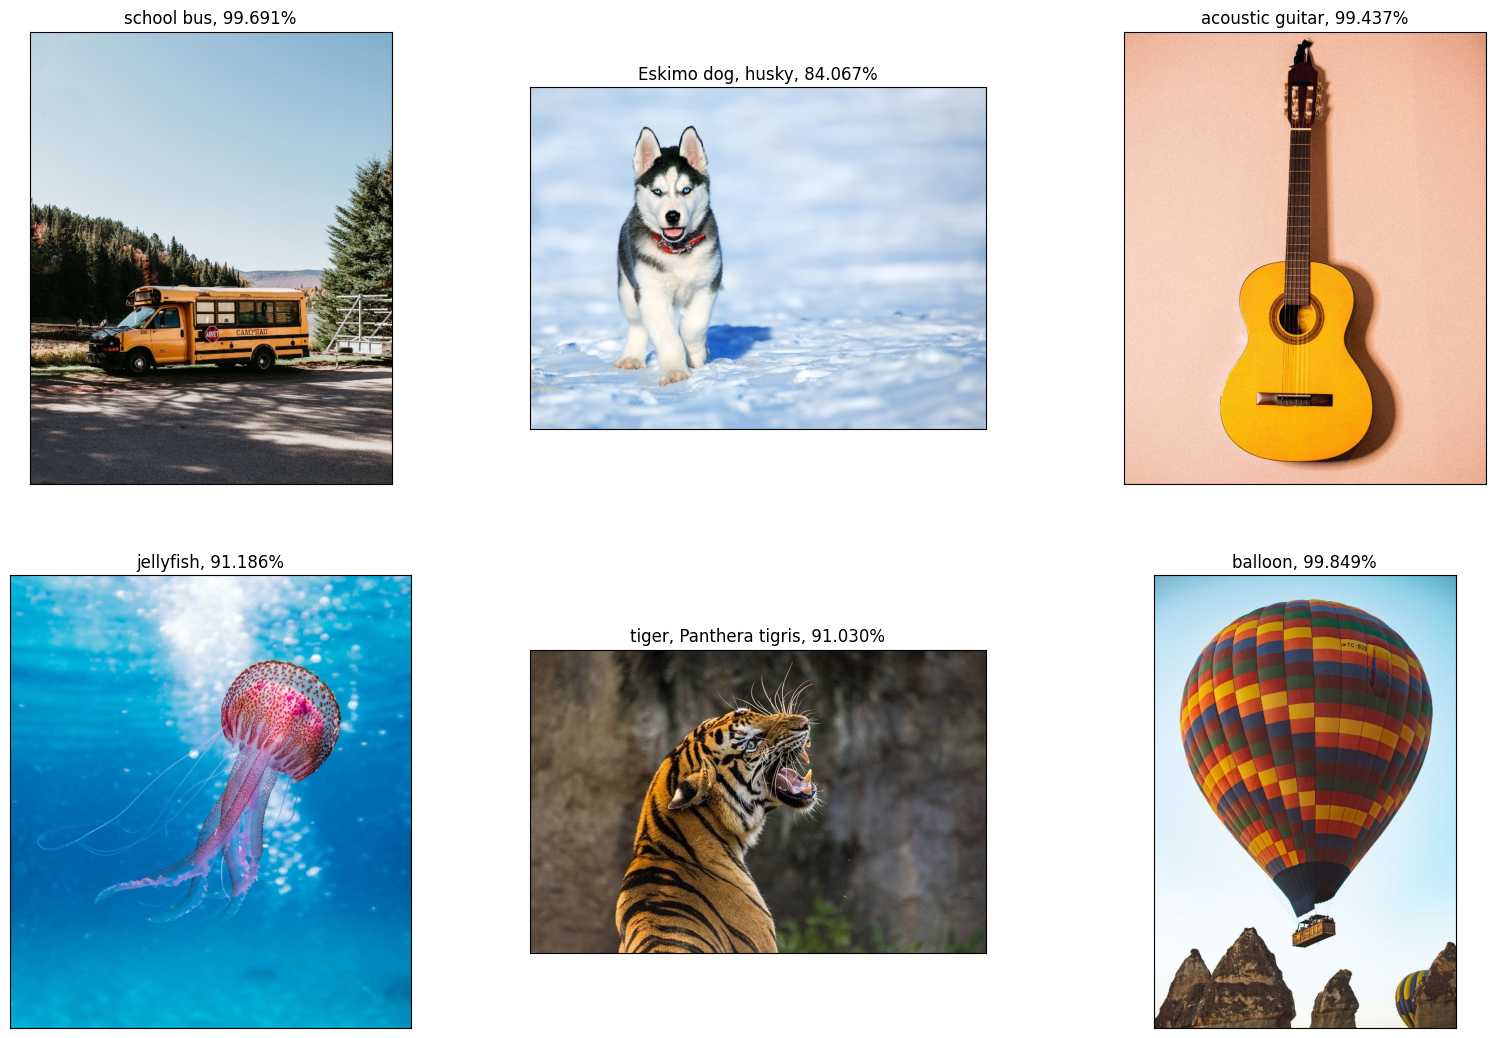

In [12]:
images = []
imageclasses = []
for img_path in glob.glob('input/*.jpg'):
    img = cv2.imread(img_path)
    images.append(img)
    print("Classifying "+img_path)
    imageclasses.append(classify(img))

plt.figure(figsize=(20, 20))

plot_count = int(len(images) / 3) + 1
for i, image in enumerate(images):
    plt.subplot(plot_count, 3, i + 1)
    plt.imshow(image[:, :, ::-1])
    plt.title(imageclasses[i])
    plt.xticks([])
    plt.yticks([])